# EfficientNet 

<img src=https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png></img>`

**Преамбула**

После просмотра кернелов на страничке соревнования я решил поробовать довольно популярную архитектуру Inception-v3. Так как вариант с предобученной сеткой прошлогоднего соревнования уже был представлен, я решил тюнить сеть с соревнования Inaturalist2017. Результат меня не удовлетворил, поэтому я изменил выбор архитектуры в пользу довольно свежего и неплохо себя показавшего семейства EfficientNet

In [1]:
# !pip install efficientnet-pytorch

In [213]:
import numpy as np
import pandas as pd
import os
import json
import time
from itertools import chain
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as f
from tqdm import tqdm_notebook
from torch.optim.lr_scheduler import StepLR, CyclicLR
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.models as models
from albumentations.augmentations import transforms
from albumentations.pytorch.transforms import ToTensor
from albumentations.core.composition import Compose
from efficientnet_pytorch import EfficientNet
import argparse
from PIL import Image
from torchvision import transforms

In [3]:
path = '/data/inaturalist2019/'

## Some EDA

In [4]:
# load train paths and labels

with open(os.path.join(path, 'train2019.json')) as data_file:
        train_anns = json.load(data_file)

train_anns_df = pd.DataFrame(train_anns['annotations'])[['image_id','category_id']]
train_img_df = pd.DataFrame(train_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})
df_train_file = pd.merge(train_img_df, train_anns_df, on='image_id')

del train_anns
del train_anns_df
del train_img_df

print(df_train_file.shape)
df_train_file.head()

(265213, 3)


,image_id,file_name,category_id
0,0,train_val2019/Plants/400/d1322d13ccd856eb4236c...,400
1,1,train_val2019/Plants/570/15edbc1e2ef000d8ace48...,570
2,2,train_val2019/Reptiles/167/c87a32e8927cbf4f06d...,167
3,3,train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...,254
4,4,train_val2019/Plants/739/ffa06f951e99de9d220ae...,739


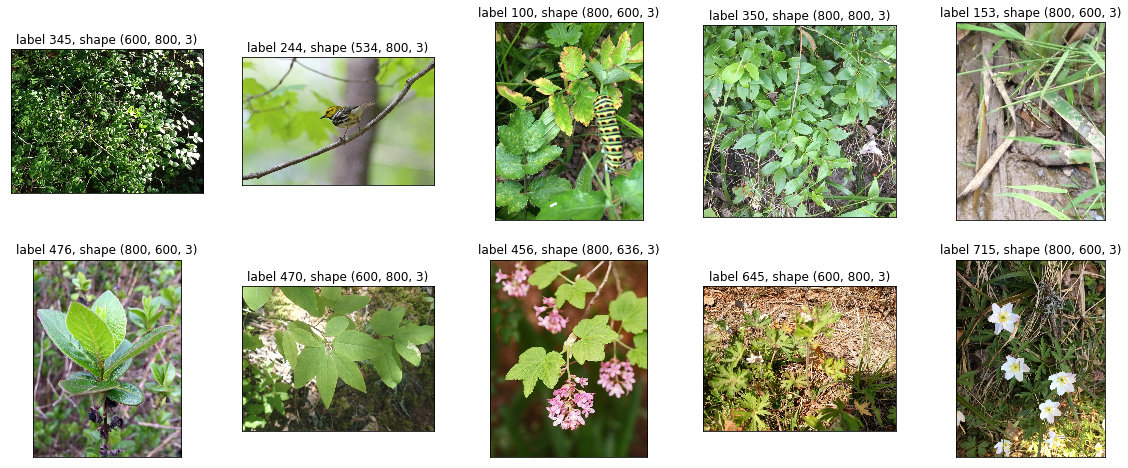

In [5]:
fig = plt.figure(figsize=(20,8))
for idx, img in enumerate(np.random.choice(df_train_file['file_name'].values, 10)):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    im = cv2.imread(os.path.join(path, img))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    labl = df_train_file.loc[df_train_file['file_name']==img, 'category_id'].values[0]
    ax.set_title(f'label {labl}, shape {im.shape}')

In [83]:
# load test paths

with open(os.path.join(path, 'test2019.json')) as data_file:
        test_anns = json.load(data_file)

df_test_file = pd.DataFrame(test_anns['images'])[['id', 'file_name']].rename(columns={'id':'image_id'})

del test_anns
print(df_test_file.shape)
df_test_file.head()

(35350, 2)


,image_id,file_name
0,268243,test2019/e295f3c7046b1f1e80c0301401324aa9.jpg
1,268244,test2019/ad3dcbb6846ed0b4dab58d7b1a4210ba.jpg
2,268245,test2019/e697be8e296b4b140cff4f96f85c364f.jpg
3,268246,test2019/7e7ba55e6aa26ba99e814d63b15d0121.jpg
4,268247,test2019/6cb6372079d23702511c06923970f13f.jpg


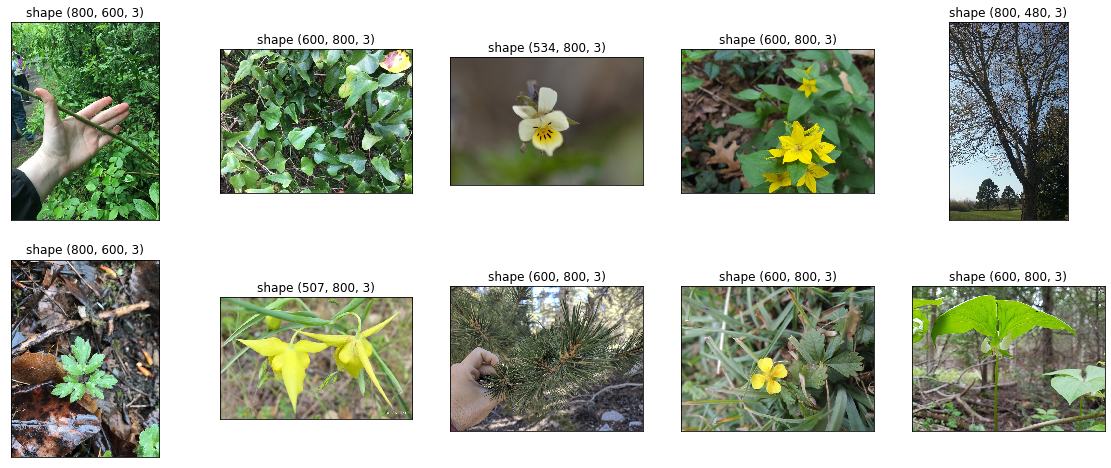

In [7]:
fig = plt.figure(figsize=(20,8))
for idx, img in enumerate(np.random.choice(df_test_file['file_name'].values, 10)):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    im = cv2.imread(os.path.join(path, img))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    ax.set_title(f'shape {im.shape}')

Картинки не всегда повернуты адекватно, размеры целевых объектов очень разные, размеры картинок разные (но не больше 800px в каждом измерении)

## Define parameters and data for modeling

In [8]:

df_train, df_valid = train_test_split(df_train_file, stratify=df_train_file['category_id'], test_size=0.2, random_state=8)

In [9]:
# parameters

par = dict(
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    model_name = 'efficientnet-b2',
    n_train = 265213,
    n_test = 35350,
    num_classes = 1010,
    batch_size = 128,
    n_workers = 12
    )

par['n_train_train'] = df_train.shape[0]
par['n_train_valid'] = df_valid.shape[0]
par['n_steps'] = int(np.ceil(par['n_train_train']/par['batch_size']))
par['image_size'] = EfficientNet.get_image_size(par['model_name']) 

for key in par.keys():
    print(key, '=', par[key])

device = cuda
model_name = efficientnet-b2
n_train = 265213
n_test = 35350
num_classes = 1010
batch_size = 128
n_workers = 12
n_train_train = 212170
n_train_valid = 53043
n_steps = 1658
image_size = 260


In [151]:
class MyDataset(Dataset):
    def __init__(self, split_data, data_root=path, transform=None, train=True):
        super().__init__()
        self.df = split_data.iloc[:,1:].values
        self.data_root = data_root
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        if self.train:
            img_name, label = self.df[index]
            img_path = os.path.join(self.data_root, img_name)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            return image, label
        else:
            img_name = self.df[index]
            img_path = os.path.join(self.data_root, img_name)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            return image

Пробовал различные виды аугментации. Изменение гаммы не зашло, как и не вполне устроил вариант с изменением размеров картинки без сохранения пропорций. Случайное выделение на картинке квадрата нужного объема тоже не подходит, так как на некоторых образцах искомый объект достаточно мал и имеет шанс не попасть в выделенную область.

In [11]:
# transforms

train_transforms = Compose([
    transforms.SmallestMaxSize(par['image_size']),
    transforms.RandomCrop(par['image_size'], par['image_size']),
    transforms.RandomRotate90(),
    transforms.Flip(),
#     transforms.RandomGamma(),
    transforms.Normalize()
])

valid_transforms = Compose([
    transforms.SmallestMaxSize(par['image_size']),
    transforms.RandomCrop(par['image_size'], par['image_size']),
    transforms.Normalize()
])

plot_transforms = Compose([
    transforms.SmallestMaxSize(par['image_size']),
    transforms.RandomCrop(par['image_size'], par['image_size']),
    transforms.RandomRotate90(),
    transforms.Flip(),
#     transforms.RandomGamma()
#     ,transforms.Normalize()
])

In [12]:
train_data = MyDataset(split_data=df_train, transform=train_transforms)
valid_data = MyDataset(split_data=df_valid, transform=valid_transforms)
plot_data = MyDataset(split_data=df_valid, transform=plot_transforms)

train_loader = DataLoader(dataset=train_data, batch_size=par['batch_size'], shuffle=True, num_workers=par['n_workers'])
valid_loader = DataLoader(dataset=valid_data, batch_size=par['batch_size'], shuffle=False, num_workers=par['n_workers'])
plot_loader = DataLoader(dataset=plot_data, batch_size=10, shuffle=True, num_workers=par['n_workers'])

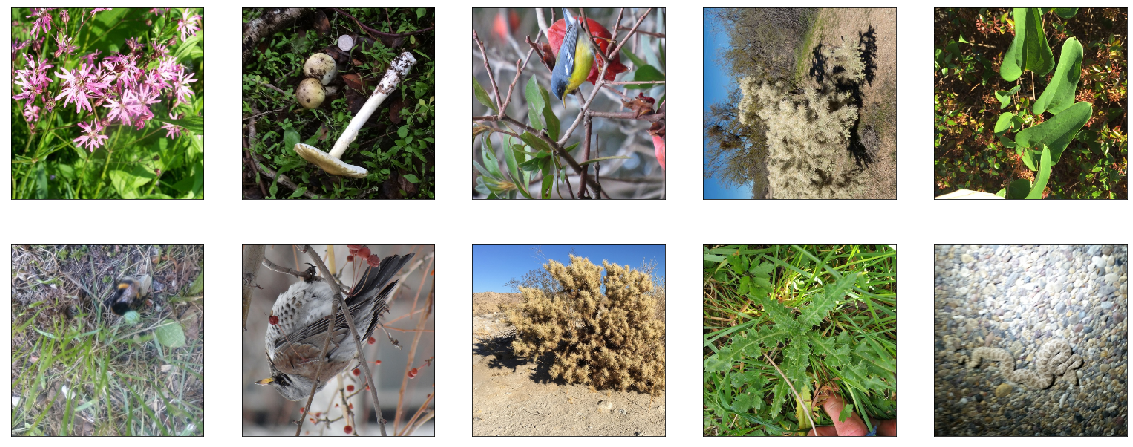

In [13]:
# plot some pictures to visualise augmentation

fig = plt.figure(figsize=(20,8))
for idx, img in enumerate(next(iter(plot_loader))[0]):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    plt.imshow(img)

Целевой метрикой в соревновании является 1-accuracy, поэтому будет смотреть на рост accuracy

In [259]:
# utils

def plot_history(train_history, val_history, epoch, title='loss'):
    plt.figure()
    plt.title(f'{title} [{epoch}]')
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='red', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    
def plot_other(x, epoch, title='time'):
    plt.figure()
    plt.title(f'{title} [{epoch}]')
    plt.plot(x)
    plt.xlabel('train steps')
    plt.grid()
    plt.show()

    
def accuracy(output, target, topk=(1,5)):
    """Computes the accuracy over the 5 top predictions"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k / batch_size)
        return res

    
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, os.path.join(path,filename))


In [160]:
def train_epoch(model, optimizer, criterion):
    losseslog = []
    top1log = []
    top5log = []
    timelog = []
    
    model.train()
    for i, (x_batch, y_batch) in enumerate(train_loader):
        end = time.time()
        data = x_batch.to(par['device'], dtype=torch.float)
        data = torch.transpose(data, 1,3)
        target = y_batch.to(par['device'])
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        pred = torch.max(output, 1)[1]
                
        acc1, acc5 = accuracy(output.data, target.data)
        losseslog.append(loss.item())
        top1log.append(acc1.item())
        top5log.append(acc5.item())
        
        loss.backward()
        optimizer.step()
        timelog.append(time.time()-end)
           
    return losseslog, top1log, top5log, timelog 
        
def valid_epoch(model, criterion):
    losseslog = []
    top1log = []
    top5log = []
    model.eval()
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        data = x_batch.to(par['device'], dtype=torch.float)
        data = torch.transpose(data, 1,3)
        target = y_batch.to(par['device'])
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        pred = torch.max(output, 1)[1]
        
        acc1, acc5 = accuracy(output.data, target.data)
        losseslog.append(loss.item())
        top1log.append(acc1.item())
        top5log.append(acc5.item())
        
        loss.backward()
        optimizer.step()
                
    return np.mean(losseslog), np.mean(top1log), np.mean(top5log)

def train(model, optimizer, criterion, batchsize, n_epochs):
    train_loss_log, train_prec1_log, train_prec5_log = [], [], []
    valid_loss_log, valid_prec1_log, valid_prec5_log = [], [], []
    time_log = []
    
    for epoch in range(n_epochs):
        
        if epoch == 10:
            for params in model._conv_head.parameters():
                params.requires_grad = True
            for params in model._bn1.parameters():
                params.requires_grad = True
        
        train_loss, train_prec1, train_prec5, train_time = train_epoch(model, optimizer, criterion)
        
        train_loss_log.extend(train_loss)
        train_prec1_log.extend(train_prec1)
        train_prec5_log.extend(train_prec5)
        time_log.extend(train_time)
        valid_loss, valid_prec1, valid_prec5 = valid_epoch(model, criterion)
        
        valid_loss_log.append((par['n_steps'] * (epoch + 1), np.mean(valid_loss)))
        valid_prec1_log.append((par['n_steps'] * (epoch + 1), np.mean(valid_prec1)))
        valid_prec5_log.append((par['n_steps'] * (epoch + 1), np.mean(valid_prec5)))
        
        scheduler.step()
        
        clear_output(1)
        plot_history(train_loss_log, valid_loss_log, epoch) 
        plot_history(train_prec1_log, valid_prec1_log, epoch, 'accuracy@1')
        plot_history(train_prec5_log, valid_prec5_log, epoch, 'accuracy@5')
        plot_other(time_log, epoch)
        

## Define model

In [16]:
# Classify with EfficientNet

model = EfficientNet.from_pretrained(par['model_name'])
for params in model.parameters():
    params.requires_grad = False
n_fc_in_features = model._fc.in_features
model._fc = nn.Linear(n_fc_in_features, par['num_classes'])
params_to_train = chain(model._conv_head.parameters(), model._bn1.parameters(), model._fc.parameters())
model = model.to(par['device'])

Loaded pretrained weights for efficientnet-b2


Будем использовать постепенно убывающий циклический learning rate

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_train, 1e-3)
scheduler = CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-1, step_size_up=1000)

На первых 10 эпохах откалибруется последний полносвязный слой, затем подключим обучение всей головы сети

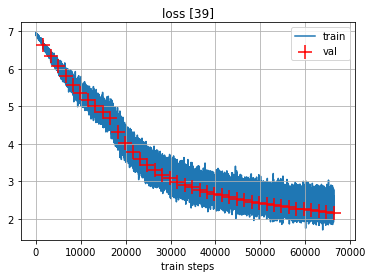

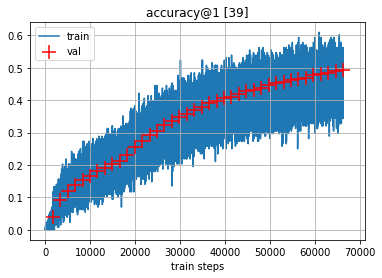

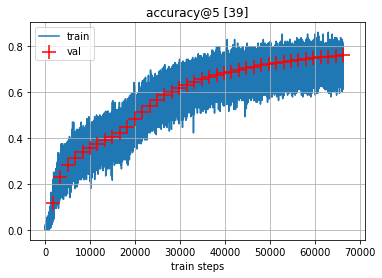

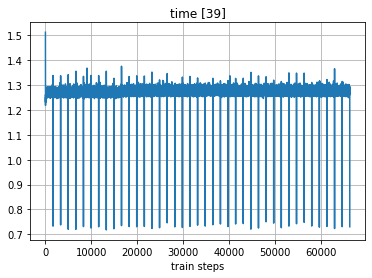

In [18]:
train(model, optimizer, criterion, par['batch_size'], 40)

In [19]:
state0 = ({'state_dict': model.state_dict(),
           'optimizer': optimizer.state_dict()})
save_checkpoint(state0, 'checkpoint2.pth.tar')

## Load pre-trained model

In [217]:
# model = EfficientNet.from_pretrained(par['model_name'])
# for params in model.parameters():
#     params.requires_grad = False
# n_fc_in_features = model._fc.in_features
# model._fc = nn.Linear(n_fc_in_features, par['num_classes'])
# params_to_train = chain(model._conv_head.parameters(), model._bn1.parameters(), model._fc.parameters())
# model = model.to(par['device'])

Loaded pretrained weights for efficientnet-b2


In [218]:
# state1 = torch.load(os.path.join(path,'checkpoint2.pth.tar'))

In [220]:
# model.load_state_dict(state1['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Можно обучать модель и дальше, что я и сделал, но, увы, не сохранил модель, хотя предикт получил. Качество продолжало расти. Но ждать уже надоело

## ***OPTIONAL tuning*** 

Далее представлена глава кода, которой я дообучал последний блок тела сети. Использовать не обязательно, но попробовать стоило

In [173]:
# model._blocks[-1]

In [174]:
# for params in model._blocks[-1]._expand_conv.parameters():
#     params.requires_grad = True
# for params in model._blocks[-1]._bn0.parameters():
#     params.requires_grad = True
# for params in model._blocks[-1]._depthwise_conv.parameters():
#     params.requires_grad = True
# for params in model._blocks[-1]._bn1.parameters():
#     params.requires_grad = True
# for params in model._blocks[-1]._se_reduce.parameters():
#     params.requires_grad = True
# for params in model._blocks[-1]._se_expand.parameters():
#     params.requires_grad = True
# for params in model._blocks[-1]._project_conv.parameters():
#     params.requires_grad = True
# for params in model._blocks[-1]._bn2.parameters():
#     params.requires_grad = True

In [175]:
# new_params_to_train = chain(model._conv_head.parameters(), model._bn1.parameters(), model._fc.parameters(),
#                             model._blocks[-1]._expand_conv.parameters(),
#                             model._blocks[-1]._bn0.parameters(),
#                             model._blocks[-1]._depthwise_conv.parameters(),
#                             model._blocks[-1]._bn1.parameters(),
#                             model._blocks[-1]._se_reduce.parameters(),
#                             model._blocks[-1]._se_expand.parameters(),
#                             model._blocks[-1]._project_conv.parameters(),
#                             model._blocks[-1]._bn2.parameters())

In [176]:
# optimizer = torch.optim.SGD(new_params_to_train, lr=1e-2)
# scheduler = CyclicLR(optimizer, base_lr=1e-2, max_lr=1e-1, step_size_up=1000)

In [177]:
# train(model, optimizer, criterion, par['batch_size'], 10)

In [178]:
# state0 = ({'state_dict': model.state_dict(),
#            'optimizer': optimizer.state_dict()})
# save_checkpoint(state0, 'checkpoint2.pth.tar')

## Make submission

In [208]:
submit_labels = pd.read_csv(os.path.join(path, 'kaggle_sample_submission.csv'))
print(submit_labels.shape)
submit_labels.head()

(35350, 2)


,id,predicted
0,268243,842
1,268244,139
2,268245,988
3,268246,612
4,268247,468


In [221]:
test_data = MyDataset(split_data=df_test_file, transform=valid_transforms, train=True)
test_loader = DataLoader(dataset=test_data, batch_size=par['batch_size'], shuffle=False, num_workers=par['n_workers'])
df_test_file['category_id'] = submit_labels['predicted']

In [222]:
def test_epoch(model):
    model.eval()
    predict = []
    for i, (x_batch, _) in enumerate(test_loader):
        data = x_batch.to(par['device'], dtype=torch.float)
        data = torch.transpose(data, 1,3)
        output = model(data)
        output = torch.argmax(output, dim=1)
        pred = output.data.cpu().numpy()
        predict.extend(pred)
    return predict        

In [223]:
submit_labels['predicted'] = test_epoch(model)

In [224]:
submit_labels.to_csv('submission.csv', index=False)

![title](Снимок.PNG)
